In [1]:
import sys
from pathlib import Path
import json

import numpy as np
import pennylane as qml
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.providers.aer import StatevectorSimulator
from qiskit.circuit.library import ZZFeatureMap
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from pandas import DataFrame

sys.path.extend(['/home/quic/QUIC-Projects/'])
from classifiers.quantum.qml.qasvm import PseudoTensorSoftQASVM
from classifiers.datasets.sklearn import SklearnDataset
from classifiers.quantum.ansatz import MultilayerCircuit9FeatureMap
from classifiers.convex.svm import CvxSoftQASVM

In [2]:
# simulation setting
dir_name = 'numerical_simulation4'
n_params_per_layer = 3

In [3]:
# setting
from pandas import read_csv
dir_path = Path.cwd() / dir_name
epsilon_summary = read_csv(dir_path/'epsilon_summary')
delta_summary = read_csv(dir_path/'delta_summary')
accuracy_summary = read_csv(dir_path/'accuracy_summary')

n_layers_list = np.array(epsilon_summary[epsilon_summary.columns[0]])
n_qubits_list = np.array(epsilon_summary.columns[1:]).astype(int)

epsilon_summary = epsilon_summary[epsilon_summary.columns[1:]]
delta_summary = delta_summary[delta_summary.columns[1:]]
accuracy_summary = accuracy_summary[accuracy_summary.columns[1:]]

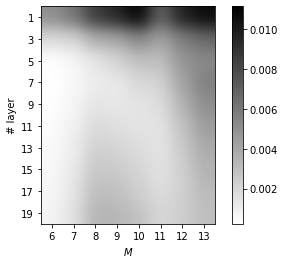

In [92]:
fig, ax = plt.subplots()
mappable = ax.imshow(epsilon_summary, cmap='binary', interpolation='gaussian')
ax.set_xlabel(r'$M$')
ax.set_ylabel('# layer')
ax.set_xticks(np.arange(len(n_qubits_list)))
ax.set_yticks(np.arange(len(n_layers_list)))
ax.set_xticklabels(n_qubits_list)
ax.set_yticklabels(n_layers_list)
fig.colorbar(mappable)

In [5]:
N_qubits, N_layers = np.meshgrid(n_qubits_list, n_layers_list)
N_qubits, N_layers

(array([[ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13],
        [ 6,  7,  8,  9, 10, 11, 12, 13]]),
 array([[ 1,  1,  1,  1,  1,  1,  1,  1],
        [ 3,  3,  3,  3,  3,  3,  3,  3],
        [ 5,  5,  5,  5,  5,  5,  5,  5],
        [ 7,  7,  7,  7,  7,  7,  7,  7],
        [ 9,  9,  9,  9,  9,  9,  9,  9],
        [11, 11, 11, 11, 11, 11, 11, 11],
        [13, 13, 13, 13, 13, 13, 13, 13],
        [15, 15, 15, 15, 15, 15, 15, 15],
        [17, 17, 17, 17, 17, 17, 17, 17],
        [19, 19, 19, 19, 19, 19, 19, 19]]))

In [6]:
N_params = n_params_per_layer*N_qubits*N_layers
# N_params = N_layers
N_params

array([[ 18,  21,  24,  27,  30,  33,  36,  39],
       [ 54,  63,  72,  81,  90,  99, 108, 117],
       [ 90, 105, 120, 135, 150, 165, 180, 195],
       [126, 147, 168, 189, 210, 231, 252, 273],
       [162, 189, 216, 243, 270, 297, 324, 351],
       [198, 231, 264, 297, 330, 363, 396, 429],
       [234, 273, 312, 351, 390, 429, 468, 507],
       [270, 315, 360, 405, 450, 495, 540, 585],
       [306, 357, 408, 459, 510, 561, 612, 663],
       [342, 399, 456, 513, 570, 627, 684, 741]])

In [7]:
epsilon_summary.to_numpy()

array([[0.00505389, 0.00614728, 0.0086612 , 0.00957487, 0.01114621,
        0.00688643, 0.00977736, 0.0107078 ],
       [0.00179371, 0.00194982, 0.00371446, 0.00396506, 0.00530337,
        0.0041465 , 0.00565386, 0.00661241],
       [0.00024471, 0.00065156, 0.00133093, 0.00208538, 0.00297294,
        0.00296965, 0.00482572, 0.00528731],
       [0.00023366, 0.00053103, 0.0010631 , 0.00121372, 0.0018702 ,
        0.00209823, 0.00417931, 0.00570635],
       [0.00031168, 0.00067114, 0.00140562, 0.00121404, 0.00142925,
        0.00167839, 0.00352207, 0.00510121],
       [0.00038971, 0.00084891, 0.00183488, 0.00161304, 0.00139413,
        0.00142947, 0.00282274, 0.00449404],
       [0.00046732, 0.00101845, 0.00225822, 0.00204528, 0.00177092,
        0.00135502, 0.00253251, 0.00387255],
       [0.00054514, 0.00118789, 0.00267374, 0.00249116, 0.00203163,
        0.00145781, 0.00229005, 0.00354269],
       [0.00062284, 0.00135777, 0.00306768, 0.00292713, 0.00229645,
        0.00170664, 0.002232

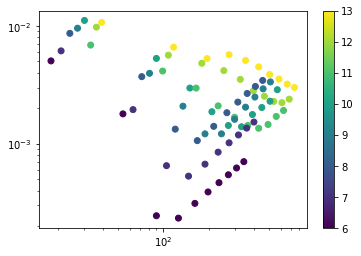

In [8]:
plt.scatter(N_params.flatten(), epsilon_summary.to_numpy().flatten(), c=N_qubits.flatten())
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

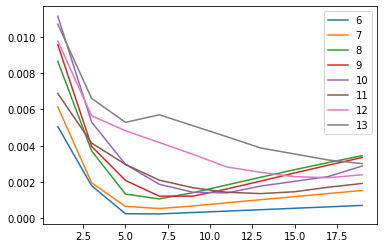

In [159]:
for i, m in enumerate(n_qubits_list):
    plt.plot(N_layers[:, i], epsilon_summary.to_numpy()[:, i], label=m)
plt.legend()

0.9899347659997028
0.9975007689682064
0.9844864984800502
0.9916195645250584
0.9970030595930868
0.9968651456740774
0.975510263207465
0.9287284461244896


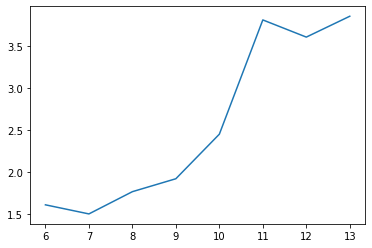

In [168]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

def f(x, A, gamma, B, C):
    return A*np.exp(-x/gamma)+B*x+C

gamma_list = []
for i, m in enumerate(n_qubits_list):
    X, Y = N_layers[:, i], epsilon_summary.to_numpy()[:, i]
    popt, pcov = curve_fit(f, X, Y, maxfev=10000, bounds=(0, np.inf))
    gamma_list.append(popt[1])
    print(r2_score(Y, f(X, *popt)))

plt.plot(n_qubits_list, gamma_list)


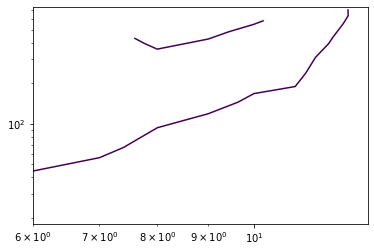

In [70]:
level = 5*np.min(epsilon_summary.to_numpy()[1:, 1:], axis=None)
c = plt.contour(N_qubits, N_params, epsilon_summary, levels=[level])
plt.xscale('log')
plt.yscale('log')

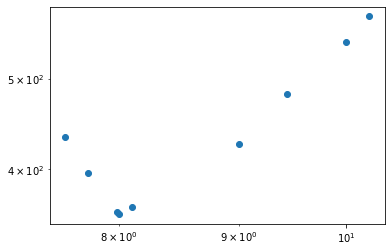

In [71]:
v = c.collections[0].get_paths()[0].vertices

plt.scatter(v[:, 0], v[:, 1])
plt.xscale('log')
plt.yscale('log')

In [80]:
from sklearn.linear_model import LinearRegression
X = N_qubits
Y = np.log2(N_layers*n_params_per_layer*N_qubits)
Z = np.log2(epsilon_summary.to_numpy())
XY = np.asarray(list(zip(X.flatten(), Y.flatten())))
ZZ = Z.flatten()
reg = LinearRegression().fit(XY, ZZ, sample_weight=(X.flatten()+Y.flatten()))
print("epsilon = O(2^{:.3f} * M^{:.3f} * (# params)^{:.3f}), R^2={:.3f}".format(reg.intercept_, reg.coef_[0], reg.coef_[1], reg.score(XY, ZZ)))

epsilon = O(2^-9.145 * M^0.396 * (# params)^-0.451), R^2=0.632


In [64]:
lv = np.log2(v)
weight = (2**lv[:, 0])
reg_ = LinearRegression().fit(lv[:, 0].reshape(-1, 1), lv[:, 1], sample_weight=weight)
print("# params = O(2^{:.3f} * log(M)^{:.3f}), R^2={:.3f}".format(reg_.intercept_, reg_.coef_[0], reg_.score(lv[:, 0].reshape(-1, 1), lv[:, 1])))

# params = O(2^-2.695 * log(M)^2.713), R^2=0.923


In [65]:
reg__ = LinearRegression().fit(2**lv[:, 0].reshape(-1, 1), lv[:, 1], sample_weight=weight)
print("# params = O(2^{:.3f} * M^{:.3f}), R^2={:.3f}".format(reg__.intercept_, reg__.coef_[0], reg__.score(2**lv[:, 0].reshape(-1, 1), lv[:, 1])))

# params = O(2^2.085 * M^0.413), R^2=0.905


Text(0.5, 1.0, '# params = $\\mathcal{O}(2^{-2.695} \\times log(M)^{2.713})$, $R^2=0.923$')

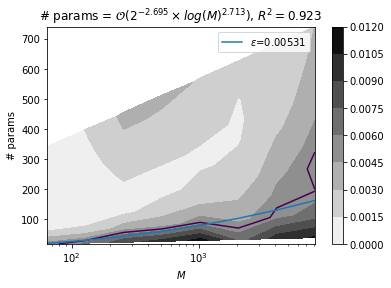

In [66]:
plt.contourf(2**N_qubits, N_params, epsilon_summary, cmap='binary')
plt.plot((2**N_qubits)[0], (2**reg_.intercept_*N_qubits**reg_.coef_[0])[0], label=r'$\epsilon$={:.5f}'.format(level))
plt.colorbar()
c = plt.contour(2**N_qubits, N_params, epsilon_summary, levels=[level])
plt.ylabel('# params')
plt.ylim([None, np.max(N_params)])
plt.xlabel(r'$M$')
plt.xscale('log')
plt.legend()
plt.title(r"# params = $\mathcal{{O}}(2^{{{:.3f}}} \times log(M)^{{{:.3f}}})$, $R^2={:.3f}$".format(reg_.intercept_, reg_.coef_[0], reg_.score(lv[:, 0].reshape(-1, 1), lv[:, 1])))

Text(0.5, 1.0, '# params = $\\mathcal{O}(2^{2.085} \\times M^{0.413})$, $R^2=0.905$')

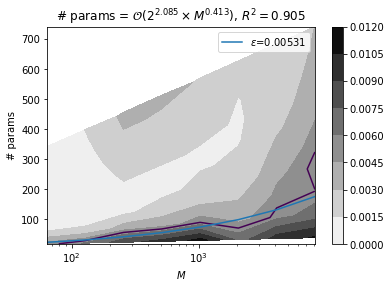

In [67]:
plt.contourf(2**N_qubits, N_params, epsilon_summary, cmap='binary')
plt.plot((2**N_qubits)[0], (2**reg__.intercept_*(2**N_qubits)**reg__.coef_[0])[0], label=r'$\epsilon$={:.5f}'.format(level))
plt.colorbar()
c = plt.contour(2**N_qubits, N_params, epsilon_summary, levels=[level])
plt.ylabel('# params')
plt.ylim([None, np.max(N_params)])
plt.xlabel(r'$M$')
plt.xscale('log')
plt.legend()
plt.title(r"# params = $\mathcal{{O}}(2^{{{:.3f}}} \times M^{{{:.3f}}})$, $R^2={:.3f}$".format(reg__.intercept_, reg__.coef_[0], reg__.score(2**lv[:, 0].reshape(-1, 1), lv[:, 1])))

In [68]:
weight = (2**lv[:, 0]).reshape(-1, 1)

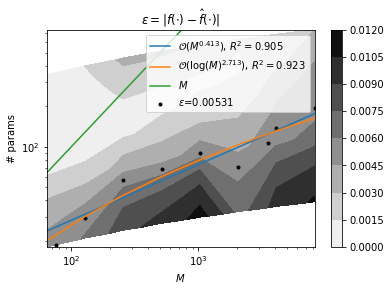

In [69]:
cmapable = plt.contourf(2**N_qubits, N_params, epsilon_summary, cmap='binary')
plt.scatter(2**v[:, 0], v[:, 1], label = r'$\epsilon$={:.5f}'.format(level), marker='.', color='k')
plt.plot((2**N_qubits)[0], (2**reg__.intercept_*(2**N_qubits)**reg__.coef_[0])[0], label=r"$\mathcal{{O}}(M^{{{:.3f}}})$, $R^2={:.3f}$".format(reg__.coef_[0], reg__.score(2**lv[:, 0].reshape(-1, 1), lv[:, 1])))
plt.plot((2**N_qubits)[0], (2**reg_.intercept_*N_qubits**reg_.coef_[0])[0], label=r"$\mathcal{{O}}(\log(M)^{{{:.3f}}})$, $R^2={:.3f}$".format(reg_.coef_[0], reg_.score(lv[:, 0].reshape(-1, 1), lv[:, 1])))
plt.plot((2**N_qubits)[0], (2**N_qubits)[0], label=r'$M$')
plt.colorbar(cmapable)
plt.ylabel('# params')
plt.ylim([None, np.max(N_params)])
plt.xlabel(r'$M$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.title(r"$\epsilon=\left|f(\cdot)-\hat{f}(\cdot)\right|$")
plt.savefig(dir_path / 'readme_figure.png', dpi=300)
plt.savefig(dir_path / 'readme_figure.pdf', dpi=300)